# Survival Analysis

Survival analysis is generally defined as a set of methods for analyzing data where the outcome variable is the time until the occurrence of an event of interest/response.

1. Time until event of death
2. Time until disease occurrence
3. Time until marriage
4. Time until divorce
5. Time until a machine part fails

The event is often referred to as a failure time, survival time, or event time. The time to event or survival time can be measured in days, weeks, years, etc. For example, if the event of interest is customer churn, then the survival time can be the time in weeks until a customer churns. In survival analysis, subjects are usually followed over a specified time period and the focus is on the time at which the event of interest occurs.

## Censoring
At the time you want to make inferences about durations, it is possible, likely true, that not all the death events have occurred yet. For example, a medical professional will not wait 50 years for each individual in the study to pass away before investigating – he or she is interested in the effectiveness of improving lifetimes after only a few years, or months possibly.

The individuals in a population who have not been subject to the death event are labeled as right-censored, i.e., we did not (or can not) view the rest of their life history due to some external circumstances. All the information we have on these individuals are their current lifetime durations (which is naturally less than their actual lifetimes).
There is also left-censoring and interval censoring.

Consider a case where the population is actually made up of two subpopulations, $A$ and $B$. Population $A$ has a very small lifespan, say 2 months on average, and population $B$ enjoys a much larger lifespan, say 12 months on average. We may not know this distinction beforehand. At $t=10$, we wish to investigate the average lifespan for everyone.

In the figure below, the red lines denote the lifespan of individuals where the death event has been observed, and the blue lines denote the lifespan of the right-censored individuals (deaths have not been observed). If we are asked to estimate the average lifetime of our population, and we naively decided to not included the right-censored individuals, it is clear that we would be severely underestimating the true average lifespan.

In [1]:
from lifelines.plotting import plot_lifetimes
import numpy as np
from numpy.random import uniform, exponential
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 25

In [3]:
CURRENT_TIME = 10

In [4]:
actual_lifetimes = np.array([ exponential(12) if (uniform() < 0.5) else exponential(2) for i in range(N)])

In [5]:
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)

In [6]:
death_observed = actual_lifetimes < CURRENT_TIME

Text(0.5, 1.0, 'Births and deaths of our population, at $t=10$')

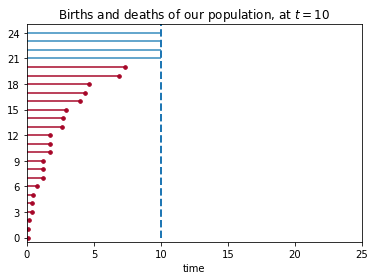

In [7]:
ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed)

ax.set_xlim(0, 25)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Births and deaths of our population, at $t=10$")

In [8]:
print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

Observed lifetimes at time 10:
 [10.          0.41177142  0.05688552  0.43308343 10.          1.18176466
  7.28662753 10.          1.68924089  4.30433316  0.10670912  0.71312457
  3.99543512  0.39982163  1.21132468  0.17496751  2.62471837  2.66137381
  1.7041819   6.88349753  4.65306461 10.          2.8973473   1.69463911
  1.19593674]


Furthermore, if we instead simply took the mean of all observed lifespans, including the current lifespans of right-censored instances, we would still be underestimating the true average lifespan. Below we plot the actual lifetimes of all instances (recall we do not see this information at $t=10$).

(0.0, 25.0)

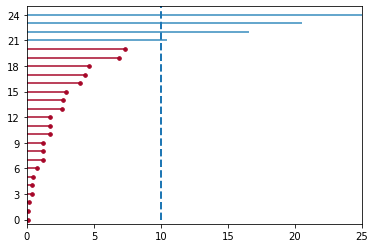

In [9]:
ax = plot_lifetimes(actual_lifetimes, event_observed=death_observed)
ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlim(0, 25)

**Survival analysis** was originally developed to solve this type of problem, that is, to deal with estimation when our data is right-censored. Even in the case where all events have been observed, i.e. no censoring, survival analysis is still a very useful tool to understand durations.

The observations need not always start at zero, either. This was done only for understanding in the above example. Consider the example where a customer entering a store is a birth: a customer can enter at any time, and not necessarily at time zero. In survival analysis, durations are relative: individuals may start at different times. (We actually only need the duration of the observation, and not necessarily the start and end time.)

## Survival function
Let $T$ be a (possibly infinite, but always non-negative) random lifetime taken from the population under study. For example, the amount of time a couple is married. Or the time it takes a user to enter a webpage (an infinite time if they never do). The survival function - $S(t)$ - of a population is defined as:

$S(t) = Pr( T > t)$

The survival function defines the probability the death event has not occurred yet at time $t$, or equivalently, the probability of surviving past time $t$. 

**The survival function has the following properties**:

1. $0 \le S(t) \le 1$
2. $F_T(t) = 1 - S(t)$ where $F_T(t)$ is the CDF of $T$, which implies
3. $S(t)$ is a non-increasing function of $t$.

## Hazard curve
We are also interested in the probability of the death event occurring at time $t$, given that the death event has not occurred until time $t$. 

Mathematically, that is: 
$\lim_{\delta t \rightarrow 0 } \; Pr( t \le T \le t + \delta t | T > t)$

This quantity goes to 0 as $\delta t$ shrinks, so we divide this by the interval $\delta t$ (like we might do in calculus). This defines the hazard function at time $t$, $h(t)$:

$h(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le T \le t + \delta t | T > t)}{\delta t}$


It can be shown that this is equal to: $h(t) = \frac{-S'(t)}{S(t)}$

and solving this differential equation, we get:

$S(t) = \exp\left( -\int_0^t h(z) \mathrm{d}z \right)$

The above equation defines all survival functions. We can now speak either about the survival function, $S(t)$, or the hazard function, $h(t)$, and we can convert back and forth quite easily. It also gives us another, expression for $T$: 


$f_T(t) = h(t)\exp\left( -\int_0^t h(z) \mathrm{d}z \right) = h(t) S(t)$



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter, LogLogisticFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [14]:
data = pd.read_csv("Telco-Customer-Churn.csv")

In [15]:
data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [16]:
print(data.shape)
display_all(data.tail().transpose())

(7043, 21)


,7038,7039,7040,7041,7042
customerID,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
gender,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,1,0
Partner,Yes,Yes,Yes,Yes,No
Dependents,Yes,Yes,Yes,No,No
tenure,24,72,11,4,66
PhoneService,Yes,Yes,No,Yes,Yes
MultipleLines,Yes,Yes,No phone service,Yes,No
InternetService,DSL,Fiber optic,DSL,Fiber optic,Fiber optic
OnlineSecurity,Yes,No,Yes,No,Yes


In [17]:
data["b_Churn"] = data.Churn.apply(lambda x: 1 if x == "Yes" else 0) #recode churn var

In [18]:
data.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

## Drop "No phone service"

In [19]:
data[data.MultipleLines != "No phone service"]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,b_Churn
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes,1


## Recode MultipleLines var to get our two comparison cohorts

In [20]:
data["b_MultipleLines"] = data.MultipleLines.apply(lambda x: 1 if x == "Yes" else 0)

This is not time series data, so we will assume all customers start at $t = 0$ 
and continue until $t = tenure$

In [21]:
data.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

## Kaplan-Meier
1. Estimates the “survival function” via the for a cohort of subjects
2. Does not provide an estimate of the magnitude of the difference in survival for the cohorts being compared
3. Each observation (case, customer) should have one "birth" (activation) and one "death" (churn)

In [22]:
kmf = KaplanMeierFitter()
T = data['tenure'] #duration
C = data["b_Churn"] #censorship - 1 if death/churn is seen, 0 if censored

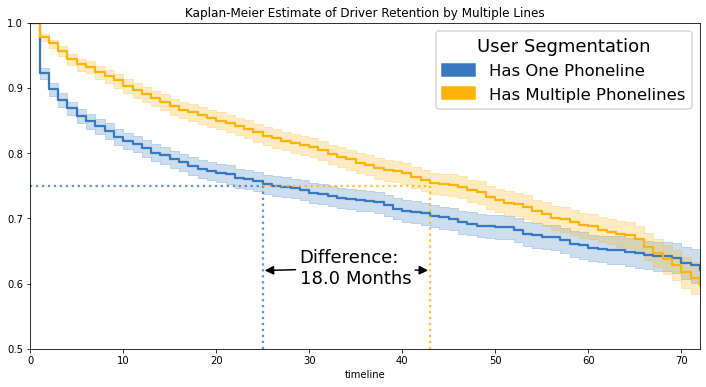

In [23]:
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0

##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
for segment in data.b_MultipleLines.unique(): 
    ix = data.b_MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
    
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1
    
##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )
##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');

Customers with one phone line have a steeper survival curve initially, but by ~4 years 3 months customer lifetime the error bars make the two groups indistinguishable.

We can see that 1 in 4 users have churned by month 25 of those who have only one phone line. By comparison, 1 in 4 users churn by month 43 among those with multiple phone lines, for a difference of 18 months (an extra 1.5 years of revenue!)

The graph clearly shows that there is a difference in tenure between "single line" and "multiple line" telco users. Since the confidence interals also appear on the graph, we can see that the difference is statistically significant from $t > 0$ until approximately $t= 52$ months, after which the churn rates becomes the same, within the margin of error.

Our survival curves do not follow the constant proportionality assumption (they cannot because they cross, and we can also see varying distances between the curves throughout). Conventionally, this would mean that a logrank test is not an appropriate measure for estimating the hazard ratio.

## To get the hazard ratio, we run the logrank test

In [24]:
multi = (data["b_MultipleLines"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          24.85 <0.005     20.62

## Log-rank test

$\log \lambda \approx \sqrt{\frac{4}{D}}$ 

In [25]:
Z = results.test_statistic
D = C.sum() #number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

3.157035574094684


The risk of churn is 3.2 times higher in users with only one phoneline compared to users with multiple lines.